In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Grid, 4x12
ROWS = 4
COLS = 12

# Learning parameters
ALPHA = 0.5      # Step size
EPSILON = 0.1    # Exploration rate
GAMMA = 1.0      # Discount factor ( no discount)
EPISODES = 500   # Number of episodes per run
RUNS = 100       # Number of independent runs to average results, resulting in better plots

In [3]:
# State defs
START_STATE = (3, 0)
GOAL_STATE = (3, 11)
CLIFF = [(3, i) for i in range(1, 11)]

# Action coding: (0,1,2,3) = (Up, Down, Left, Right)
ACTIONS = [0, 1, 2, 3]

In [4]:
# Environment transition logic
def step(state, action):
    r, c = state
    if action == 0:   # Up
        r = max(r - 1, 0)
    elif action == 1: # Down
        r = min(r + 1, ROWS - 1)
    elif action == 2: # Left
        c = max(c - 1, 0)
    elif action == 3: # Right
        c = min(c + 1, COLS - 1)

    next_state = (r, c)
    
    # Cliff fall
    if next_state in CLIFF:
        return START_STATE, -100, False
    
    # Goal reached
    if next_state == GOAL_STATE:
        return next_state, -1, True
    
    # Default transition
    return next_state, -1, False


# Epsilon-greedy action selection
def choose_action(state, q_table):
    if np.random.rand() < EPSILON:
        return np.random.choice(ACTIONS)
    else:
        values = q_table[state[0], state[1], :]
        # Choose randomly if actions have the same value
        return np.random.choice([a for a, v in enumerate(values) if v == np.max(values)])


In [5]:
def sarsa():
    q_table = np.zeros((ROWS, COLS, len(ACTIONS)))
    rewards_log = []

    for _ in range(EPISODES):
        state = START_STATE
        action = choose_action(state, q_table)
        total_reward = 0
        done = False
        
        while not done:
            next_state, reward, done = step(state, action)
            next_action = choose_action(next_state, q_table)
            
            # Sarsa Update
            target = reward + GAMMA * q_table[next_state[0], next_state[1], next_action]
            error = target - q_table[state[0], state[1], action]
            q_table[state[0], state[1], action] += ALPHA * error
            
            state = next_state
            action = next_action
            total_reward += reward
            
        rewards_log.append(total_reward)
    return rewards_log

In [6]:

def q_learning():
    q_table = np.zeros((ROWS, COLS, len(ACTIONS)))
    rewards_log = []

    for _ in range(EPISODES):
        state = START_STATE
        total_reward = 0
        done = False
        
        while not done:
            action = choose_action(state, q_table)
            next_state, reward, done = step(state, action)
            
            # Q-Learning Update
            best_next_q = np.max(q_table[next_state[0], next_state[1], :])
            target = reward + GAMMA * best_next_q
            error = target - q_table[state[0], state[1], action]
            q_table[state[0], state[1], action] += ALPHA * error
            
            state = next_state
            total_reward += reward
            
        rewards_log.append(total_reward)
    return rewards_log

In [7]:
def run_simulation():

    sarsa_total = np.zeros(EPISODES)
    q_learning_total = np.zeros(EPISODES)

    for i in range(RUNS):
        sarsa_total += np.array(sarsa())
        q_learning_total += np.array(q_learning())

    # Calculate averages
    sarsa_avg = sarsa_total / RUNS
    q_learning_avg = q_learning_total / RUNS
    
    return sarsa_avg, q_learning_avg


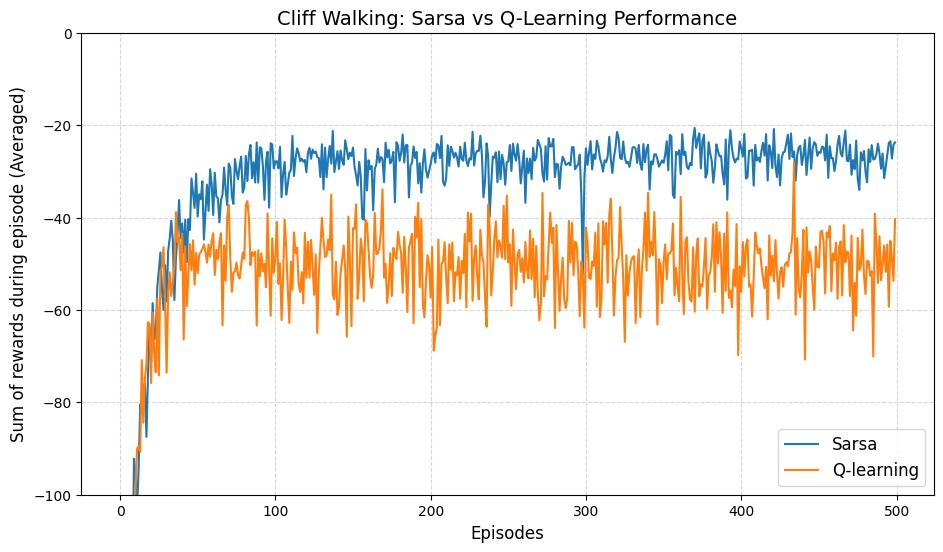

In [8]:
sarsa_res, q_res = run_simulation()

plt.figure(figsize=(11, 6))

# Plotting smoothed curves for better visualization
plt.plot(sarsa_res, label='Sarsa', linewidth=1.5)
plt.plot(q_res, label='Q-learning', linewidth=1.5)

plt.title('Cliff Walking: Sarsa vs Q-Learning Performance', fontsize=14)
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Sum of rewards during episode (Averaged)', fontsize=12)
plt.ylim(-100, 0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=12)

plt.show()

Simulation results shows the fundamental difference between on-policy (Sarsa) and off-policy (Q-learning) RL in the Cliff Walking environment.

Sarsa: Learns a safer path. Because it updates its Q-values based on the actual actions taken, it realizes that walking near the edge is dangerous. If the agent makes a random move while standing on the edge, it falls. Sarsa factors this risk into its policy, leading it to choose a longer but safer route.

Q-Learning: Learns the optimal path. It ignores the danger of exploration during the update step and focuses on the maximum possible future rewards. Thus it learns the path directly along the cliff's edge. While this path is shorter, the agent's online performance is worse because its epsilon-greedy exploration occasionally causes it to fall off the cliff, resulting in large negative reward spikes.

While Q-learning converges to the absolute optimal policy, Sarsa provides better online performance in environments where mistakes are highly penalized.